# Laboratorio de arreglos adaptativos


*   Manuel Mollon, Legajo: 58023
*   Ezequiel Vijande, Legajo: 58057



## Librerias

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import get_window

## 1. Modelar la respuesta de un arreglo de M sensores espaciados por la distancia d a una señal de banda base compleja x(n) modulada a una frecuencia de longitud de onda $\lambda_c$ y proveniente desde la dirección $φ_s$. Asumir que x(n) se presenta en el primer sensor del arreglo sin retardo. La función debe cumplir con el prototipo: $$def \quad model\_signal(M, d, x, lambda\_c, phi\_s)$$

In [2]:

def model_signal(M,d,x,lambda_c,phi_s):
  try:
    size_x = len(x)
  except:
    size_x = 1
  response = np.zeros( shape=(size_x,M), dtype=complex )
  #Modelo el vector con el delay correspondiente a cada sensor
  phase = -1j*( 2*math.pi*d*np.sin(phi_s)*np.linspace(start=0,stop=M-1,num=M,dtype=int) )/lambda_c
  v = np.exp( phase )
  if ( np.isscalar(x) ):
    response = x*v
  else:
    for i in range(0,size_x):
      response[i] = x[i] * v
  return response

def MakeSubplot(x,y,fig,row,column,index,title):
  fig.add_subplot(row,column,index)
  plt.title(title)
  plt.plot(x,y)
  plt.grid(True)
  plt.xlim(left=-90,right=90)


In [3]:
lambda_c = 5
x=1
phi_s=0.25*math.pi
M=6
d=7
result = model_signal(M,d,x,lambda_c,phi_s)
print(result)

[1.        +0.j         0.99800675+0.06310723j 0.99203495+0.12596288j
 0.98210841+0.18831639j 0.9682667 +0.24991917j 0.950565  +0.31052565j]


## 2. Modelar el ruido térmico de energía $\sigma^2$ de un arreglo de M sensores para N instantes temporales. La función debe cumplir con el prototipo: $$def \quad model\_noise(M, N, sigma\_2)$$

In [4]:
def model_noise(M,N,sigma_2):
  return np.random.normal(scale=np.sqrt(sigma_2), size=(N,M) )

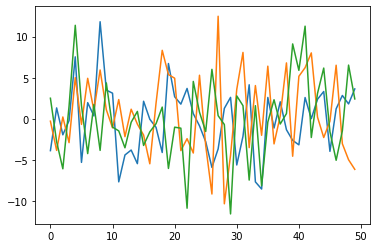

In [5]:
N=50
M=3
sigma_2 = 20
plt.plot( model_noise(M,N,sigma_2) )
plt.show()

## 3. Aprovechando las funciones del punto 1 y 2, estimar el espectro de potencia espacial de una señal de banda base compleja compuesta por una señal $x_1(n)$ de ruido blanco gaussiano de media cero proveniente desde $φ_{s_1} = -45°$ y energía $σ^2_{x_1} = 1$, y una señal $x_2(n)$ de ruido blanco gaussiano de media cero proveniente desde $φ_{s_2} = -65°$ y energía $σ^2_{x_2} = 0.1$. La señal es electromagnética, se transmite por aire y es modulada a $F_c = 3GHz$; el ruido de los sensores es $σ^2_n = 0.005$. Para un taper con ventana rectangular y un taper con ventana de Hamming:

In [32]:
def GetMatchedCoefs(M,d,lambda_c,phi_s):
  phase = -1j*( 2*math.pi*d*np.sin(phi_s)*np.linspace(start=0,stop=M-1,num=M,dtype=int) )/lambda_c
  return ( 1/np.sqrt(M) )*np.exp( phase )

def CalcBeamPattern(M,c_vect,N=None):
  if N== None:
    n_fft = M
  else:
    n_fft = N
  beam_pattern = np.fft.fftshift((abs(np.fft.fft(c_vect,n=N))**2))/M
  c_freqs = np.fft.fftshift(np.fft.fftfreq(n=N))
  phi_vect = np.arcsin( (lambda_c*c_freqs)/d ) *(180/math.pi)
  return phi_vect, np.flip(beam_pattern)

def GetSpatialSpectrum(M,d,lambda_c,x,window="boxcar"):
  angles= np.linspace(start=-math.pi/2,stop=math.pi/2, num=512)
  spectrum = np.zeros(len(angles))
  if (window == "hanning"):
    taper = get_window("hanning",M)
    for i in range(0,len(angles)):
      angle = angles[i]
      c_vect = GetMatchedCoefs(M, d, lambda_c, angle)
      tapered_c = taper*c_vect
      norm = np.sqrt( np.dot( np.conj(tapered_c),tapered_c) )
      spectrum[i] = ( abs(np.dot(x,np.conj(tapered_c / norm)))**2 ).mean()
  else:
    for i in range(0,len(angles)):
      angle = angles[i]
      c_vect = GetMatchedCoefs(M, d, lambda_c, angle)
      spectrum[i] = ( abs(np.dot(x,np.conj(c_vect)))**2 ).mean()
  return angles,spectrum

### a) Determinar la cantidad de sensores M y el espaciamiento d óptimo.

Del Criterio de Nyquist espacial se tiene que para no sufrir de aliasing se debe cumplir con:
$$ d\leq \frac{\lambda}{2} $$
Si la señal puede aproximarse como de banda angosta ($BW<<F_c$) entonces se puede tomar:
 $$\lambda=\lambda_c=\frac{c}{F_c}=0.1m$$ 
 Donde $c$ es la velocidad de la luz y $F_c$ la frecuencia temporal de la portadora.

Por lo que se tiene que la separacion maxima posible sin sufrir aliasing sera de:
$$d_{max}=\frac{\lambda_c}{2}=0.05m$$ 

Tambien existe una relacion entre la separacion d de los sensores y la resolucion en frecuencia. Definiendo la apertura como:
$$L=M\cdot d$$ 
Se tiene que el ancho del lobulo principal del patron de directividad es:
$$\triangle \phi_{3dB}\approx \frac{\lambda}{L}$$

La señales se encuentran a una distancia angular de $20°$. Para poder distinguir cada señal con su filtro espacial ajustado correspondiente, se considera que la señal que no se esta observando debe ser atenuada a la misma energia que la del piso de ruido. Por lo que se tiene que el peor caso es cuando se observa $x_2$ y se debe atenuar $x_1$, se tiene que:
$$\frac{\sigma_{x_1}}{\sigma_n}=20=13dB$$
Para que se logre atenuar 13dB a 20°, asumiendo que la atenuacion incrementa linealmente se debe cumplir que:
$$\frac{\triangle \phi}{2}=\frac{20°\cdot 3dB}{13dB}$$
$$\triangle \phi=10°$$

Copn dicho valor de ancho para lobulo principal se llega a que el valor de M necesario es de al menos:
$$L=M\cdot d \approx \frac{\lambda}{\triangle \phi_{3dB}}$$
$$M \approx \frac{0.1}{\frac{\pi}{18}\cdot \frac{0.1}{2}}=12$$
Dado lo explicado previamente, como conviene elegir el d lo mas grande posible para tener una mayor apertura y asi una mejor resolucion en frecuencia, tambien debe cumplir con el criterio de Nyquist espacial para no tener aliasing. Ademas de esto, para cumplir con la resolucion en frecuencia deseada, se determino que se necesita un M=40.Esto se determino graficando el espectro de potencia espacial para distintos valores de M y viendo que este es el minimo valor necesario para distinguir correctamente ambos lobulos principales para ambos tapers.Por lo que los valores optimos son:
$$d_{opt}=0.05m$$
$$M_{opt}=40$$

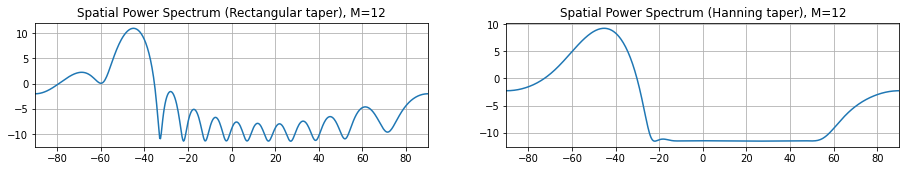

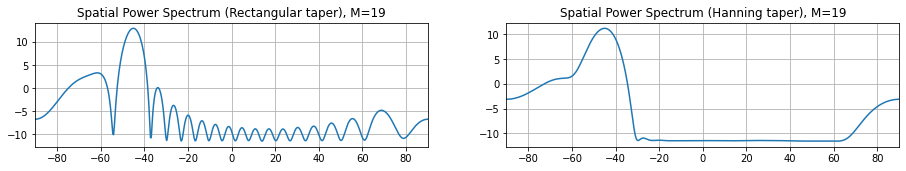

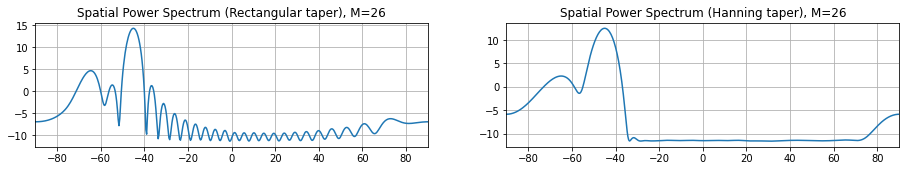

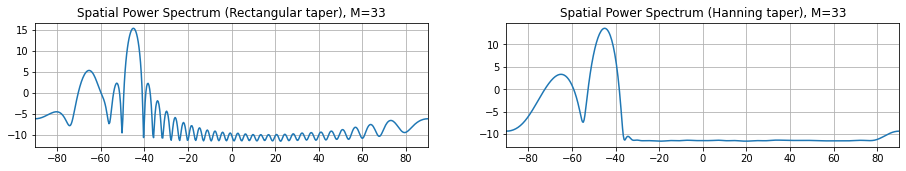

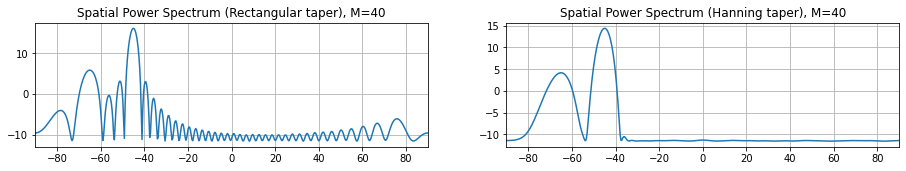

In [37]:
#Parametros
N = 4096
sigma_x1 = 1
sigma_x2 = np.sqrt(0.1)
sigma_n = np.sqrt(0.005)
phi_x1 = -45 *(math.pi/180) #Angulo de arribo de x1 en radianes
phi_x2 = -65 *(math.pi/180) #Angulo de arribo de x2 en radianes
Fc = 3e9                    #Frecuencia de portadora de 3GHZ
lambda_c = 3e8/Fc
d = lambda_c /2
#Modelado de las señales
x1 = np.random.normal(scale = sigma_x1, size=N )
x2 = np.random.normal(scale = sigma_x2, size=N )
m_values = np.linspace(start=12,stop=40,num=5,dtype=int)
for i in range(0,len(m_values)):
  M = m_values[i]
  noise= model_noise(M,N,sigma_n)
  #Señal recibida
  r1 = model_signal(M,d,x1,lambda_c,phi_x1)
  r2 = model_signal(M,d,x2,lambda_c,phi_x2)
  recieved = r1 + r2 + noise
  #Calculo espectro
  phi_vect, spectrum = GetSpatialSpectrum(M,d,lambda_c,recieved)
  phi_vect_hann, spectrum_hann = GetSpatialSpectrum(M,d,lambda_c,recieved,"hanning")
  fig_a = plt.figure(figsize=(12,10))
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
  MakeSubplot(phi_vect*(180/math.pi), 10*np.log10(spectrum),fig_a,5,2,2*i+1,title="Spatial Power Spectrum (Rectangular taper), M="+str(M))
  MakeSubplot(phi_vect_hann*(180/math.pi), 10*np.log10(spectrum_hann),fig_a,5,2,2*i+2,title="Spatial Power Spectrum (Hanning taper), M="+str(M))
plt.show()

### b) Determinar la cantidad de instantes temporales N óptima.

El espectro de potencia espacial se define como:
$$R(\phi )=E\{ |C^H(\phi)\cdot x(n)|^2 \}$$

### c) Determinar la cantidad de puntos óptima para el barrido de φ.

### d) Representar el espectro de potencia espacial en función de φ.

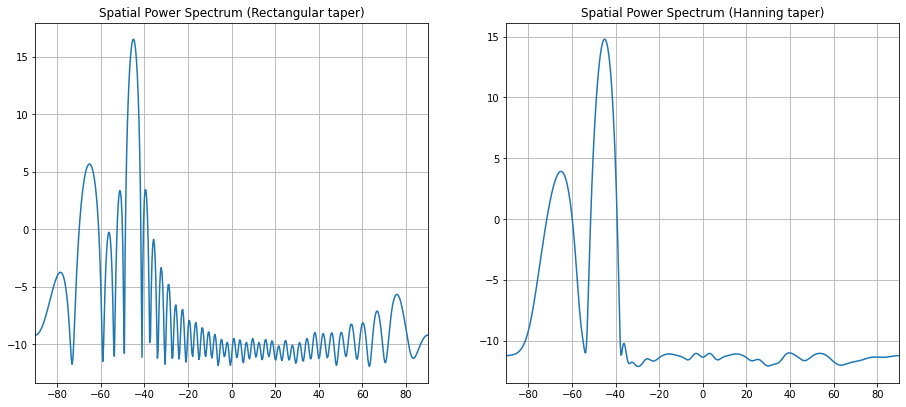

In [40]:
#Parametros
N = 252
M= 40
sigma_x1 = 1
sigma_x2 = np.sqrt(0.1)
sigma_n = np.sqrt(0.005)
phi_x1 = -45 *(math.pi/180) #Angulo de arribo de x1 en radianes
phi_x2 = -65 *(math.pi/180) #Angulo de arribo de x2 en radianes
Fc = 3e9                    #Frecuencia de portadora de 3GHZ
lambda_c = 3e8/Fc
d = lambda_c /2
#Modelado de las señales
x1 = np.random.normal(scale = sigma_x1, size=N )
x2 = np.random.normal(scale = sigma_x2, size=N )
noise= model_noise(M,N,sigma_n)
#Señal recibida
r1 = model_signal(M,d,x1,lambda_c,phi_x1)
r2 = model_signal(M,d,x2,lambda_c,phi_x2)
recieved = r1 + r2 + noise
#Calculo espectro
phi_vect, spectrum = GetSpatialSpectrum(M,d,lambda_c,recieved)
phi_vect_hann, spectrum_hann = GetSpatialSpectrum(M,d,lambda_c,recieved,"hanning")
fig_a = plt.figure(figsize=(12,5))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
MakeSubplot(phi_vect*(180/math.pi), 10*np.log10(spectrum),fig_a,1,2,1,title="Spatial Power Spectrum (Rectangular taper)")
MakeSubplot(phi_vect_hann*(180/math.pi), 10*np.log10(spectrum_hann),fig_a,1,2,2,title="Spatial Power Spectrum (Hanning taper)")
plt.show()

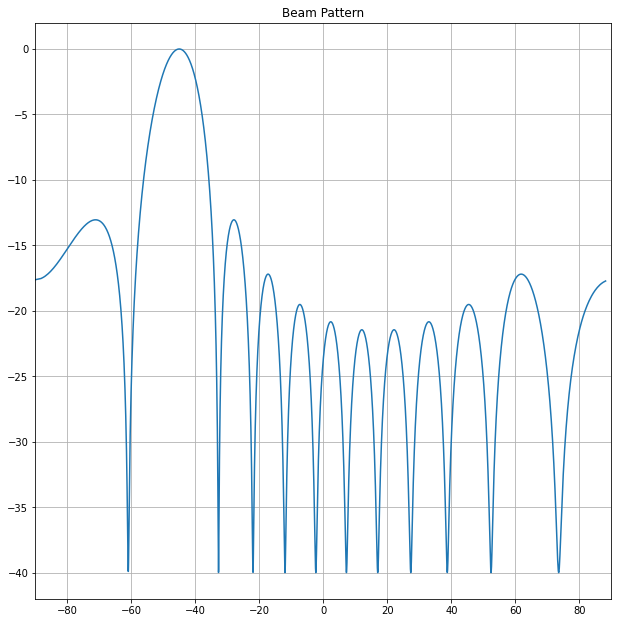

In [9]:
#Parametros
N = 4096
M= 12
sigma_x1 = 1
sigma_x2 = np.sqrt(0.1)
sigma_n = np.sqrt(0.005)
phi_x1 = -45 *(math.pi/180) #Angulo de arribo de x1 en radianes
phi_x2 = -65 *(math.pi/180) #Angulo de arribo de x2 en radianes
Fc = 3e9                    #Frecuencia de portadora de 3GHZ
lambda_c = 3e8/Fc
d = lambda_c /2

c_vect = GetMatchedCoefs(M,d,lambda_c,phi_x1)
phi_vect , beam_pattern = CalcBeamPattern(M,c_vect,N)
fig_a = plt.figure(figsize=(8,8))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
MakeSubplot(phi_vect, 10*np.log10(beam_pattern+1e-4),fig_a,1,1,1,title="Beam Pattern")
plt.show()

## 4. Para las señales del ejercicio anterior, con M = 16 y $d = \frac{λ}{2}$, y asumiendo que $x_1(n)$ es una señal de interés y $x_2(n)$ una interferencia, determinar el beamformer SMI óptimo y estimar su loss SINR en función del ángulo φ.

In [10]:
def SampleMatrixInversion(x):
  K = x.shape[0]
  M = x.shape[1]
  result = np.zeros(shape=(M,M))
  for i in range(0,K):
    result = result + (1/K)*np.matmul( x[i].reshape(M,1), np.conj(x[i]).reshape(1,M)  )
  return result

def GetCoefsAndLossSINR(x,d,lambda_c,phi_s, sigma_w):
  M = x.shape[1]
  r = SampleMatrixInversion(x) 
  inv_r= np.linalg.inv( r ) #Sample Matrix inversion
  phase = -1j*( 2*math.pi*d*np.sin(phi_s)*np.linspace(start=0,stop=M-1,num=M,dtype=int) )/lambda_c
  v = (1/np.sqrt(M))*np.exp( phase ) #Vector respuesta del arreglo
  c = np.matmul(inv_r,v.reshape(M,1))
  den = np.dot( np.conj(v), c)[0]
  c_opt = c / den
  #Caluclo la SINR loss
  angle_array = np.linspace(start=-math.pi/2,stop=math.pi/2, num=180)
  loss_array = np.zeros(angle_array.shape, dtype=complex)
  for i in range(0,len(angle_array)):
    angle = angle_array[i]
    phase = -1j*( 2*math.pi*d*np.sin(angle)*np.linspace(start=0,stop=M-1,num=M,dtype=int) )/lambda_c
    v = (1/np.sqrt(M))*np.exp( phase ) #Vector respuesta del arreglo
    c = np.matmul(inv_r,v.reshape(M,1))
    den = np.dot( np.conj(v), c)[0]
    loss_array[i] = (sigma_w**2)*den
  return c_opt,  loss_array 


In [11]:
#Parametros
N = 4096
M= 16
sigma_x1 = 1
sigma_x2 = np.sqrt(0.1)
sigma_n = np.sqrt(0.005)
phi_x1 = -45 *(math.pi/180) #Angulo de arribo de x1 en radianes
phi_x2 = -65 *(math.pi/180) #Angulo de arribo de x2 en radianes
Fc = 3e9                    #Frecuencia de portadora de 3GHZ
lambda_c = 3e8/Fc
d = lambda_c /2

#Modelado de las señales
x1 = np.random.normal(scale = sigma_x1, size=N )
x2 = np.random.normal(scale = sigma_x2, size=N )
noise= model_noise(M,N,sigma_n)
#Señal recibida
recieved = model_signal(M,d,x2,lambda_c,phi_x2) + noise
coefs, losses = GetCoefsAndLossSINR(recieved,d,lambda_c,phi_x1, sigma_n)

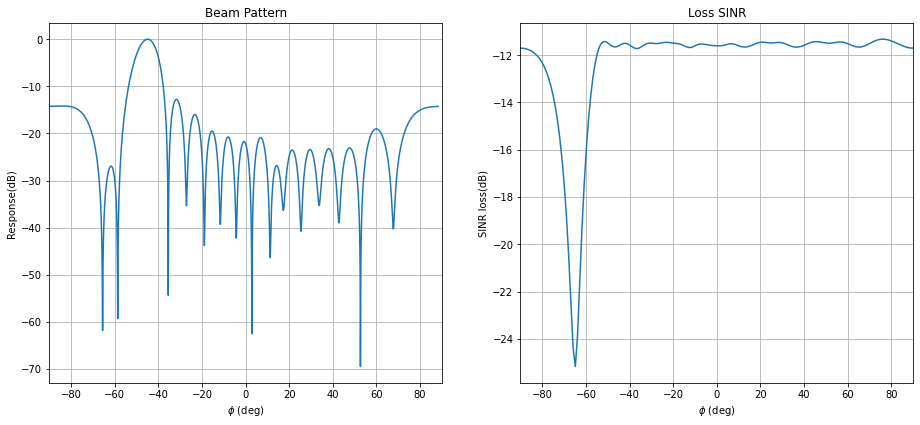

In [12]:
phi_vect, beam_pattern = CalcBeamPattern(M,coefs.reshape(M),N)
angle_array = np.linspace(start=-90,stop=90, num=180)

fig_a = plt.figure(figsize=(12,5))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.2, wspace = 0.2)
MakeSubplot(phi_vect, 10*np.log10(beam_pattern+1e-9),fig_a,1,2,1,title="Beam Pattern")
plt.ylabel("Response(dB)")
plt.xlabel("$\phi$ (deg)")
MakeSubplot(angle_array, 10*np.log10(abs(losses)),fig_a,1,2,2,title="Loss SINR")
plt.ylabel("SINR loss(dB)")
plt.xlabel("$\phi$ (deg)")
plt.show()